<a href="https://colab.research.google.com/github/fatimaiqbal27/Underwater-Image-Restoration/blob/main/Underwater_restoration_updated_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

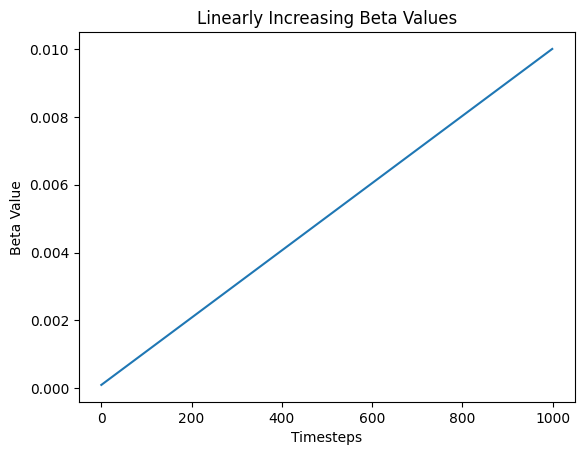

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter

import torch
import numpy as np
from scipy.ndimage import gaussian_filter

def generate_turbidity_noise(shape, device):
    """
    Generates Gaussian noise for forward diffusion.
    """
    # Generate uniform noise in the range [-1, 1]
    noise = (torch.rand(shape) * 2 - 1).cpu().numpy()

    # Apply Gaussian blur to smooth the noise (corrected)
    for channel in range(noise.shape[1]):  # Apply blur per channel
        noise[:, channel, :, :] = gaussian_filter(noise[:, channel, :, :], sigma=15)  # FIXED: Assign result back

    return torch.tensor(noise, dtype=torch.float32).to(device)  # Convert back to tensor

def forward_diffusion_sample(x_0, t, learnable_beta, alphas_cumprod):
    """
    Diffuses the input image by adding evenly distributed noise at timestep t.
    """

    beta_t = get_index_from_list(learnable_beta(), t, x_0.shape)

    alpha_cumprod_t = 1 - beta_t  # Correctly indexed cumulative product
    sqrt_alpha_cumprod_t = torch.sqrt(alpha_cumprod_t)
    sqrt_one_minus_alpha_cumprod_t = torch.sqrt(1. - alpha_cumprod_t)

    # Generate Gaussian noise
    noise = generate_turbidity_noise(x_0.shape, device=x_0.device)

    # Apply noise with controlled spread
    noisy_image = sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise

    return noisy_image, noise



class LearnableBeta(nn.Module):
    def __init__(self, timesteps, beta_start=1e-4, beta_end=0.02):
        super(LearnableBeta, self).__init__()
        self.timesteps = timesteps
        self.beta_scalar = nn.Parameter(torch.tensor(0.01))  # Learnable scalar for beta

    def forward(self):
        # Linearly interpolate between beta_start and beta_scalar
         beta_values = torch.lerp(torch.full((self.timesteps,), 1e-4, device=self.beta_scalar.device),
                         self.beta_scalar.expand(self.timesteps),
                         torch.linspace(0, 1, steps=self.timesteps, device=self.beta_scalar.device))


         return beta_values


def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


class LearnableSigma(nn.Module):
    def __init__(self, initial_sigma=10.0):
        super(LearnableSigma, self).__init__()
        self.sigma = nn.Parameter(torch.tensor(initial_sigma))  # Learnable sigma parameter

    def forward(self, t):
        return self.sigma  # Can be modified to be time-dependent if needed




# Main Execution
device = "cpu"
timesteps = 1000

learnable_beta = LearnableBeta(timesteps=timesteps).to(device)
learnable_sigma = LearnableSigma().to(device)
betas1 = learnable_beta().detach()
# Compute Derived Parameters for Diffusion
betas = learnable_beta()
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, 0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# Posterior Variance Calculation
posterior_variance = betas[:-1] * (1. - alphas_cumprod[:-1]) / (1. - alphas_cumprod[1:])

# Visualization of Linearly Increasing Beta
plt.plot(betas1.cpu().numpy())
plt.xlabel("Timesteps")
plt.ylabel("Beta Value")
plt.title("Linearly Increasing Beta Values")
plt.show()

In [ ]:
print("learnable_beta requires grad:", learnable_beta.beta_scalar.requires_grad)  # Should be True
print("betas requires grad:", betas.requires_grad)  # Should be True
print("posterior_variance shape:", posterior_variance.shape)  # Ensure valid shape
print("loss requires grad:", loss.requires_grad)



learnable_beta requires grad: True
betas requires grad: True
posterior_variance shape: torch.Size([999])


NameError: name 'loss' is not defined

Epoch [1/5], Loss: 0.00022868516091897537, Beta: 0.009999999776482582, Sigma: 10.0
Displaying first 50 noisy images for Epoch 1:


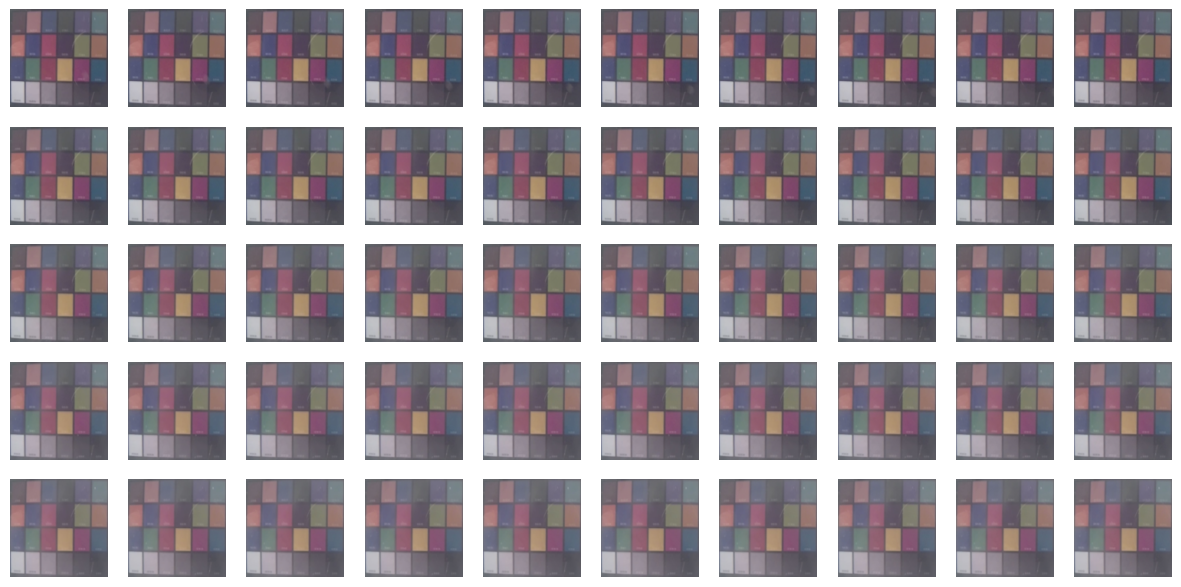

Epoch [2/5], Loss: 0.0002313247724050956, Beta: 0.009999999776482582, Sigma: 10.0
Displaying first 50 noisy images for Epoch 2:


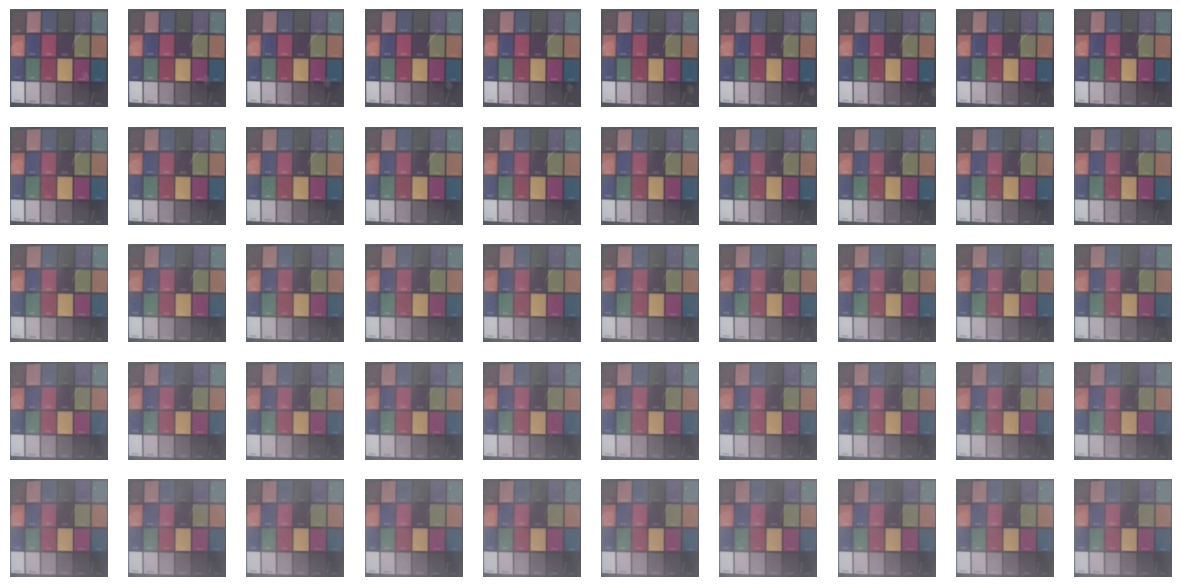

Epoch [3/5], Loss: 0.00023162375368122548, Beta: 0.009999999776482582, Sigma: 10.0
Displaying first 50 noisy images for Epoch 3:


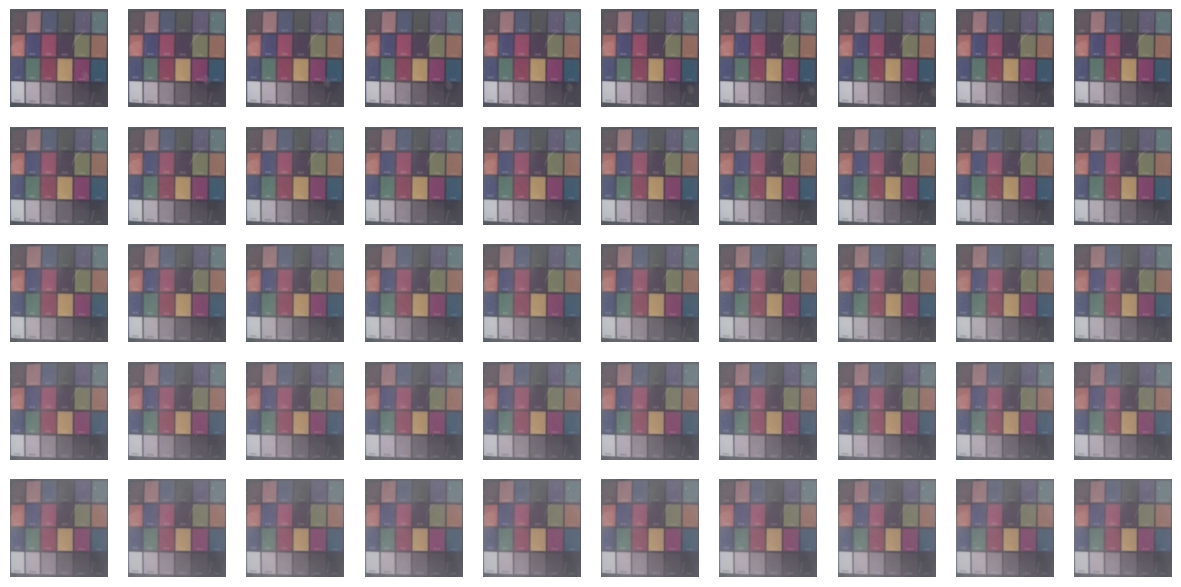

Epoch [4/5], Loss: 0.00023137964974457147, Beta: 0.009999999776482582, Sigma: 10.0
Displaying first 50 noisy images for Epoch 4:


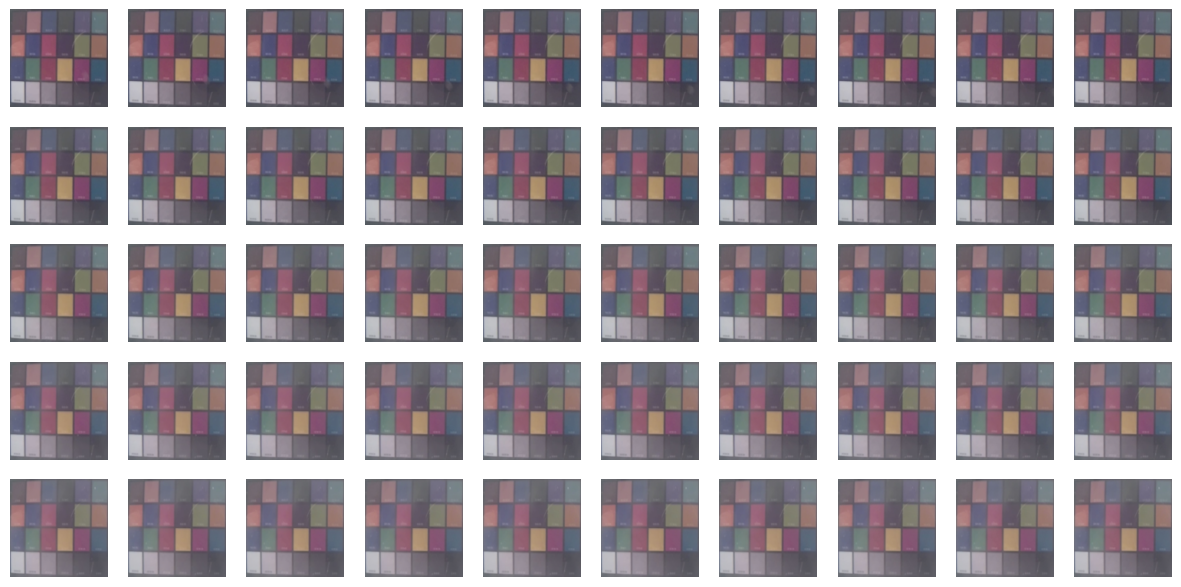

Epoch [5/5], Loss: 0.00023451777793862956, Beta: 0.009999999776482582, Sigma: 10.0
Displaying first 50 noisy images for Epoch 5:


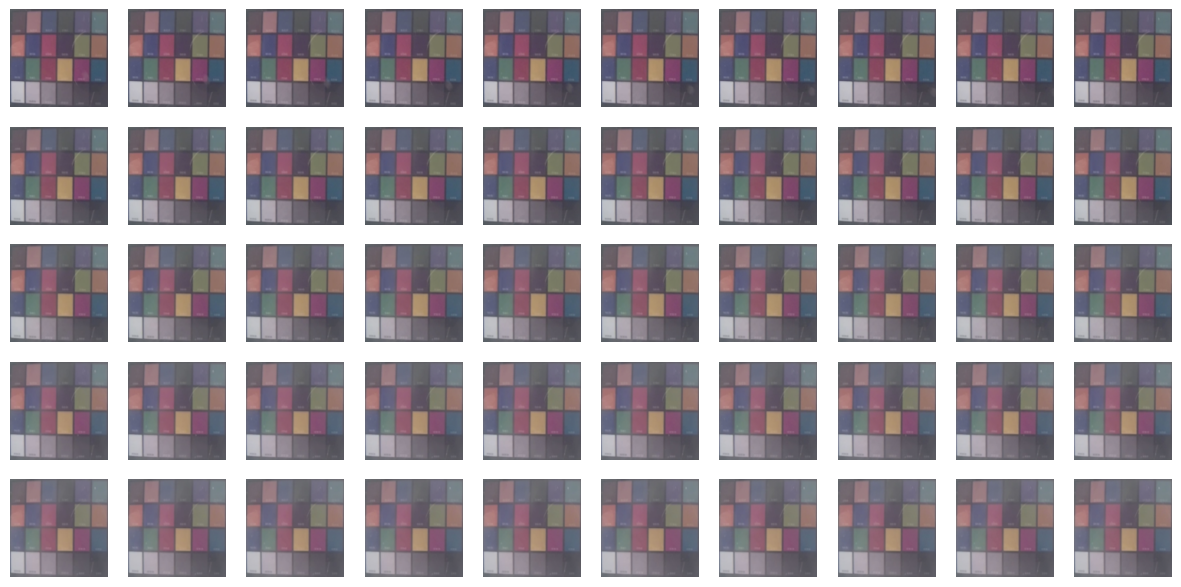

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

import re
import torchvision.transforms.functional as TF


# Define constants
IMG_SIZE = 128
T = 1000  # Number of timesteps
device = 'cpu'

# Transformation pipeline for input images
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize to consistent size
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
])

# Define your image path and directory
image_path = '/content/drive/MyDrive/Colab Notebooks/turbid  water images/10000.jpg'
ground_truth_dir = '/content/drive/MyDrive/Colab Notebooks/turbid  water images'

# Load ground truth images
ground_truth_images = []
ground_truth_files = sorted(
    os.listdir(ground_truth_dir),
    key=lambda x: int(re.search(r'^\d+', x).group()) if re.search(r'^\d+', x) else float('inf')
)[:1000]

for img_file in ground_truth_files:
    img_path = os.path.join(ground_truth_dir, img_file)
    image = Image.open(img_path).convert('RGB')  # Ensure 3-channel RGB
    image_tensor = data_transforms(image)  # Apply transformations
    ground_truth_images.append(image_tensor.unsqueeze(0))  # Add batch dimension

# Combine all ground truth tensors into a single batch
ground_truth_images = torch.cat(ground_truth_images).to(device)  # Shape: (batch_size, channels, height, width)

# Initialize learnable parameters


# Optimizer setup
optimizer = optim.Adam([
    {'params': learnable_beta.parameters()},
    {'params': learnable_sigma.parameters()}
], lr=1e-3)

# Initialize the lists to store average epoch loss, beta, and sigma values
losses = []
beta_values = []
sigma_values = []

# Training loop
epochs = 5
num_display_images = 50  # Number of noisy images to display
t = torch.randint(0, T, (1,), device=device)  # Random timestep

for epoch in range(epochs):
    epoch_loss = 0
    noisy_image_list = []  # Reset noisy image list for each epoch

    for i in range(len(ground_truth_images)-1):
        t = torch.randint(0, T, (1,), device=device)  # Random timestep
        x_0 = ground_truth_images[i].unsqueeze(0).to(device).requires_grad_()  # Use ground truth image directly
        x_1 = ground_truth_images[i+1].unsqueeze(0).to(device).requires_grad_()  # Use ground truth image directly
        # Perform forward diffusion sampling with dynamically updated beta
        noisy_image, noise = forward_diffusion_sample(x_0, t, learnable_beta, alphas_cumprod)

        # Save the noisy image to the list for visualization
        if i < num_display_images:  # Only save the first 100 images
            noisy_image_list.append(noisy_image.detach().cpu())  # Detach from computation graph

        actual_noise = x_1-x_0

        # Compute loss (predicted noise vs actual noise)
        loss = F.mse_loss(noise, actual_noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Log the epoch loss, beta, and sigma values
    losses.append(epoch_loss / len(ground_truth_images))
    beta_values.append(learnable_beta.beta_scalar.item())
    sigma_values.append(learnable_sigma.sigma.item())

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {losses[-1]}, Beta: {beta_values[-1]}, Sigma: {sigma_values[-1]}")

    # Visualize the first 100 noisy images for the current epoch
    print(f"Displaying first {num_display_images} noisy images for Epoch {epoch + 1}:")
    plt.figure(figsize=(15, 15))
    for idx in range(min(num_display_images, len(noisy_image_list))):
        plt.subplot(10, 10, idx + 1)  # Create a grid of 10x10 images
        img = (noisy_image_list[idx].squeeze(0).permute(1, 2, 0).numpy() + 1) / 2  # Convert to [0, 1]
        plt.imshow(img.clip(0, 1))
        plt.axis("off")
    plt.show()

# Save the trained model parameters
torch.save({
    'learnable_beta': learnable_beta.state_dict(),
    'learnable_sigma': learnable_sigma.state_dict(),
}, 'trained_model.pth')


Epoch [1/5], Loss: 0.00023175336090774498, Beta: 0.009999999776482582, Sigma: 10.0
Epoch [2/5], Loss: 0.00023249847411530738, Beta: 0.009999999776482582, Sigma: 10.0
Epoch [3/5], Loss: 0.0002301948627087146, Beta: 0.009999999776482582, Sigma: 10.0
Epoch [4/5], Loss: 0.00023105388209700216, Beta: 0.009999999776482582, Sigma: 10.0
Epoch [5/5], Loss: 0.0002318517218566429, Beta: 0.009999999776482582, Sigma: 10.0
Displaying final predicted noise, actual noise, and ground truth images:


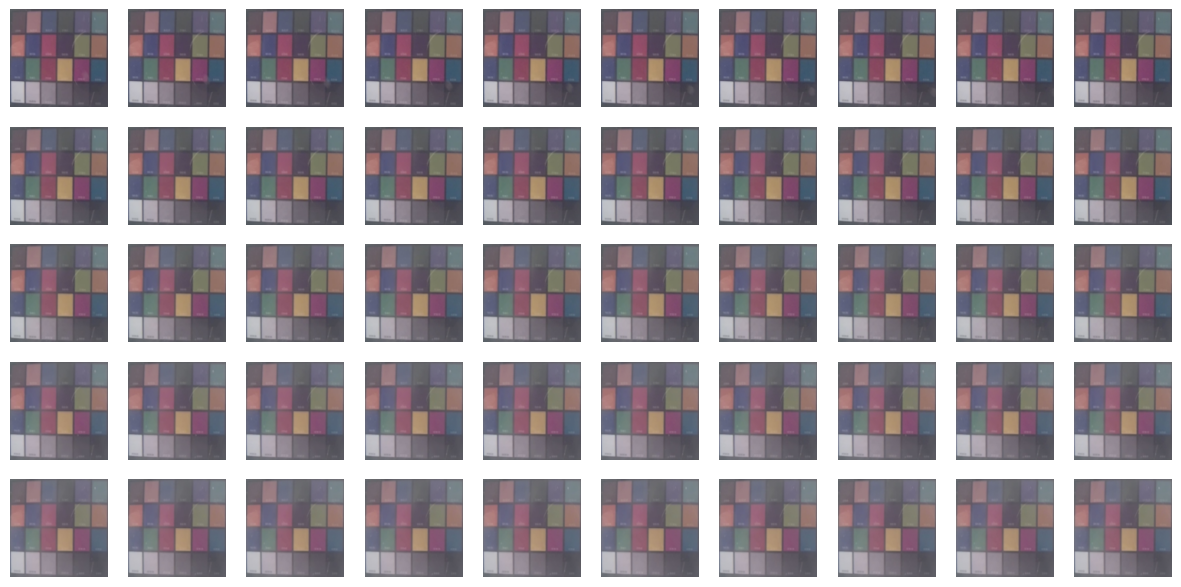

Displaying final predicted noise:


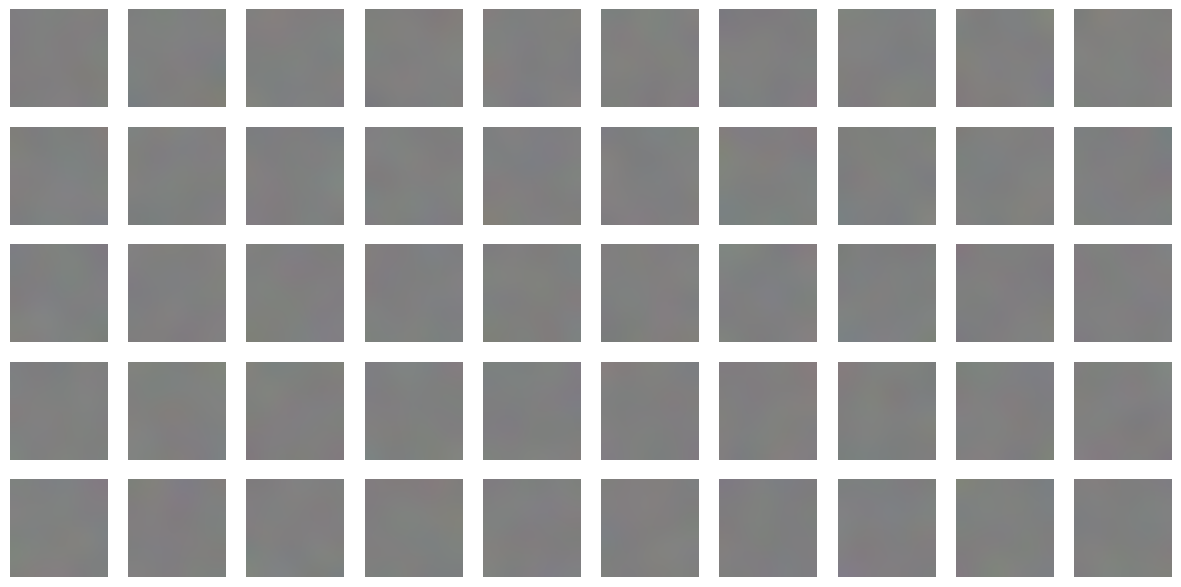

Displaying actual noise:


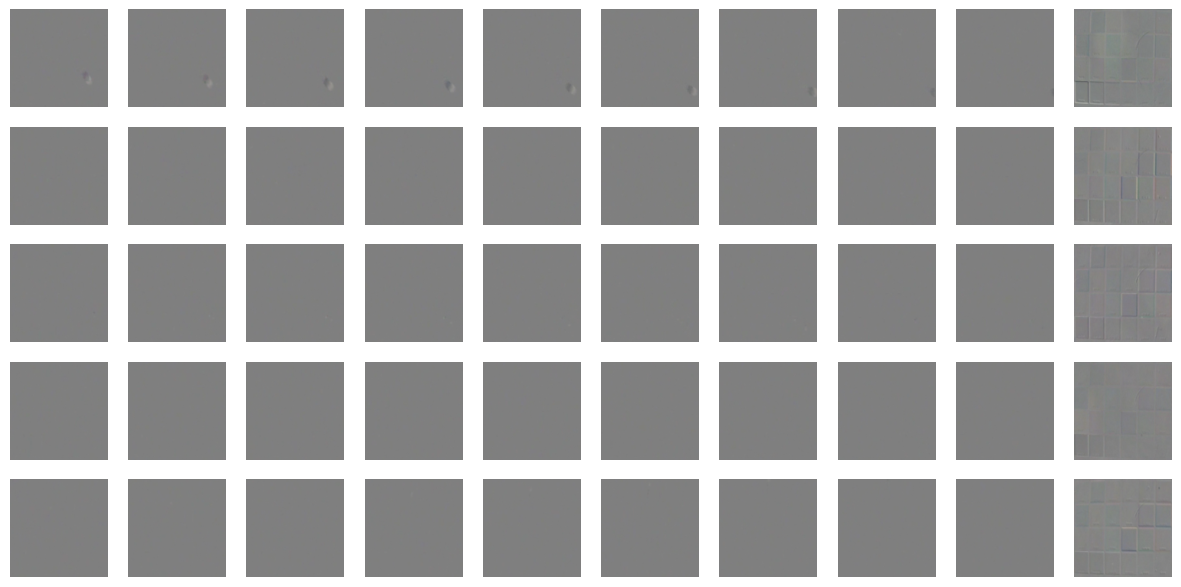

In [ ]:
# Initialize lists to store final results
final_predicted_noise_list = []
final_actual_noise_list = []
final_ground_truth_image_list = []

for epoch in range(epochs):
    epoch_loss = 0
    noisy_image_list = []  # Reset noisy image list for each epoch
    predicted_noise_list = []  # To store predicted noise for visualization
    actual_noise_list = []  # To store actual noise for visualization
    ground_truth_image_list = []  # To store ground truth images for visualization

    for i in range(len(ground_truth_images) - 1):
        t = torch.randint(0, T, (1,), device=device)  # Random timestep
        x_0 = ground_truth_images[i].unsqueeze(0).to(device).requires_grad_()  # Mark as requiring gradients
        x_1 = ground_truth_images[i + 1].unsqueeze(0).to(device).requires_grad_()  # Mark as requiring gradients

        # Forward diffusion process (predict noisy image and noise)
        noisy_image, predicted_noise = forward_diffusion_sample(x_0, t, learnable_beta, alphas_cumprod)

        # Compute actual noise as the difference between x_1 and x_0
        actual_noise = x_1 - x_0  # Expected noise in the dataset

        # Save the noisy image for visualization
        if i < num_display_images:
            noisy_image_list.append(noisy_image.detach().cpu())  # Detach from computation graph
            predicted_noise_list.append(predicted_noise.detach().cpu())  # Predicted noise
            actual_noise_list.append(actual_noise.detach().cpu())  # Actual noise
            ground_truth_image_list.append(x_0.detach().cpu())  # Ground truth image (x_0)

        # Compute loss between predicted noise and actual noise
        loss = F.mse_loss(predicted_noise, actual_noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Log the epoch loss, beta, and sigma values
    losses.append(epoch_loss / len(ground_truth_images))
    beta_values.append(learnable_beta.beta_scalar.item())
    sigma_values.append(learnable_sigma.sigma.item())

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {losses[-1]}, Beta: {beta_values[-1]}, Sigma: {sigma_values[-1]}")

# Visualizing Final Results after all epochs
print("Displaying final predicted noise, actual noise, and ground truth images:")

# Display Final Ground Truth Images (first few)
plt.figure(figsize=(15, 15))
for idx in range(min(num_display_images, len(ground_truth_image_list))):
    plt.subplot(10, 10, idx + 1)
    img = (ground_truth_image_list[idx].squeeze(0).permute(1, 2, 0).numpy() + 1) / 2  # Convert to [0, 1]
    plt.imshow(img.clip(0, 1))
    plt.axis("off")
plt.show()

print("Displaying final predicted noise:")

# Display Final Predicted Noise
plt.figure(figsize=(15, 15))
for idx in range(min(num_display_images, len(predicted_noise_list))):
    plt.subplot(10, 10, idx + 1)
    noise_img = (predicted_noise_list[idx].squeeze(0).permute(1, 2, 0).numpy() + 1) / 2
    plt.imshow(noise_img.clip(0, 1))
    plt.axis("off")
plt.show()

print("Displaying actual noise:")
plt.figure(figsize=(15, 15))
for idx in range(min(num_display_images, len(actual_noise_list))):
    plt.subplot(10, 10, idx + 1)
    noise_img = (actual_noise_list[idx].squeeze(0).permute(1, 2, 0).numpy() + 1) / 2
    plt.imshow(noise_img.clip(0, 1))
    plt.axis("off")
plt.show()


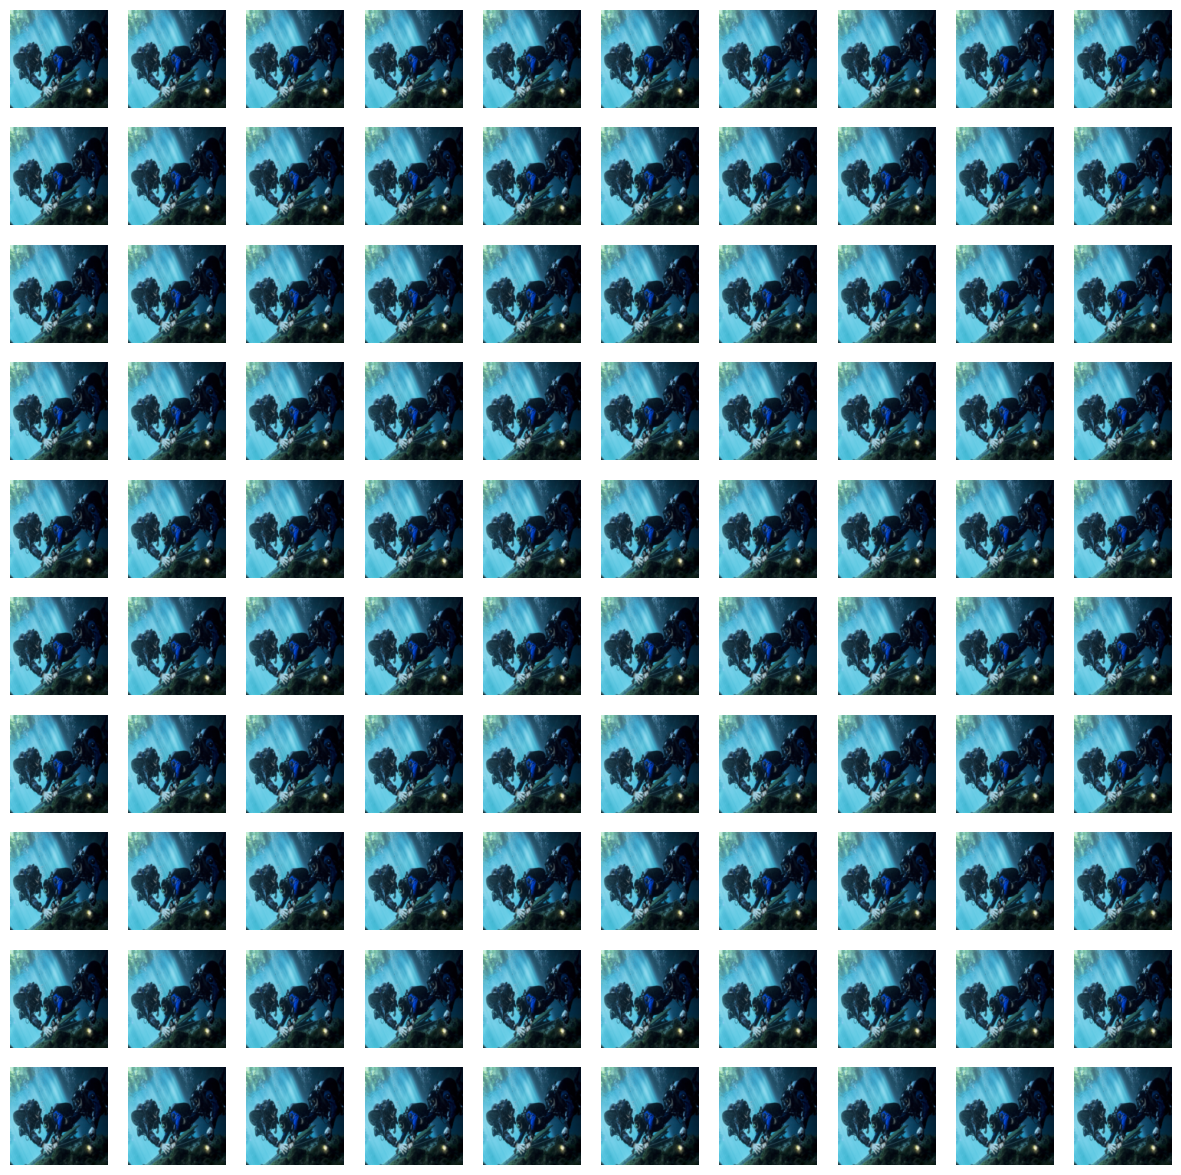

In [ ]:
test_noisy_image_list=[]
num_display_images_1=1000
TO=500
for i in range(1000):
    tI = torch.randint(0, TO, (1,), device=device)  # Random timestep
    test_image_path = '/content/GENERAL_FRONT_Jarrod_Jablonski_0.jpg'
    test_image = Image.open(test_image_path).convert('RGB')
    test_image_tensor = data_transforms(test_image)
    x_4 = test_image_tensor.unsqueeze(0).to(device).requires_grad_()

        # Perform forward diffusion sampling with dynamically updated beta
    test_noisy_image, test_noise = forward_diffusion_sample(x_4, tI, learnable_beta, alphas_cumprod)
    test_noisy_image_list.append(test_noisy_image.detach().cpu())  # Detach from computation graph

plt.figure(figsize=(15, 15))
for idx in range(100):
    plt.subplot(10, 10, idx+1)  # Adjust grid size according to the number of images
    noise_img = (test_noisy_image_list[idx].squeeze(0).permute(1, 2, 0).numpy() + 1) / 2
    plt.imshow(noise_img.clip(0,1))
    plt.axis("off")
plt.show()


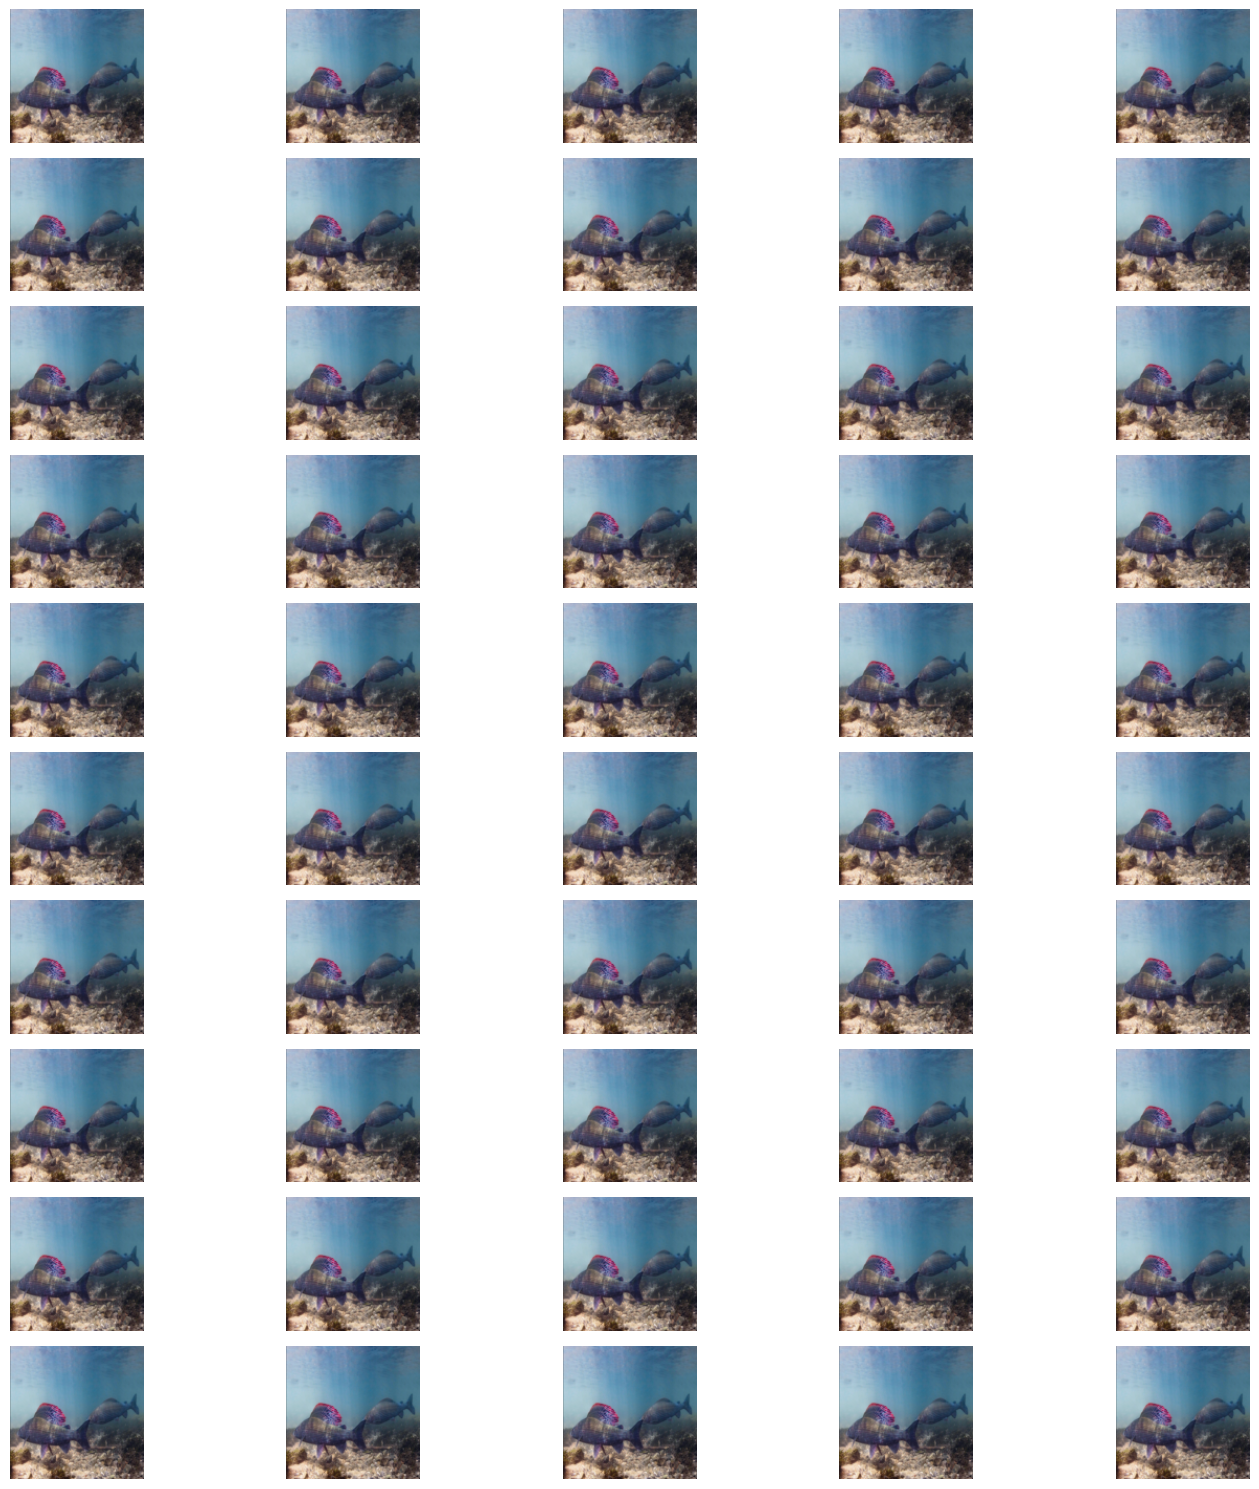

In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Initialize list to store noisy images
test_noisy_image_list = []
TO = 500
num_iterations = 1000

for _ in range(num_iterations):
    tI = torch.arange(0, TO, device=device)  # Sequential timesteps

    test_image_path = '/content/drive/MyDrive/underwater ımages/Screenshot from 2025-02-24 20-03-09.png'
    test_image = Image.open(test_image_path).convert('RGB')
    test_image_tensor = data_transforms(test_image)
    x_4 = test_image_tensor.unsqueeze(0).to(device).requires_grad_()

    # Perform forward diffusion sampling
    test_noisy_images, test_noises = forward_diffusion_sample(x_4, tI, learnable_beta, alphas_cumprod)

    # Store noisy images and keep only the last 50
    test_noisy_image_list.extend(test_noisy_images.detach().cpu())
    if len(test_noisy_image_list) > 50:
        test_noisy_image_list = test_noisy_image_list[-50:]

# Display the last 50 images
plt.figure(figsize=(15, 15))
for idx, img in enumerate(test_noisy_image_list):
    plt.subplot(10, 5, idx + 1)  # 10 rows, 5 columns
    noise_img = (img.squeeze(0).permute(1, 2, 0).numpy() + 1) / 2
    plt.imshow(noise_img.clip(0, 1))
    plt.axis("off")
plt.tight_layout()
plt.show()


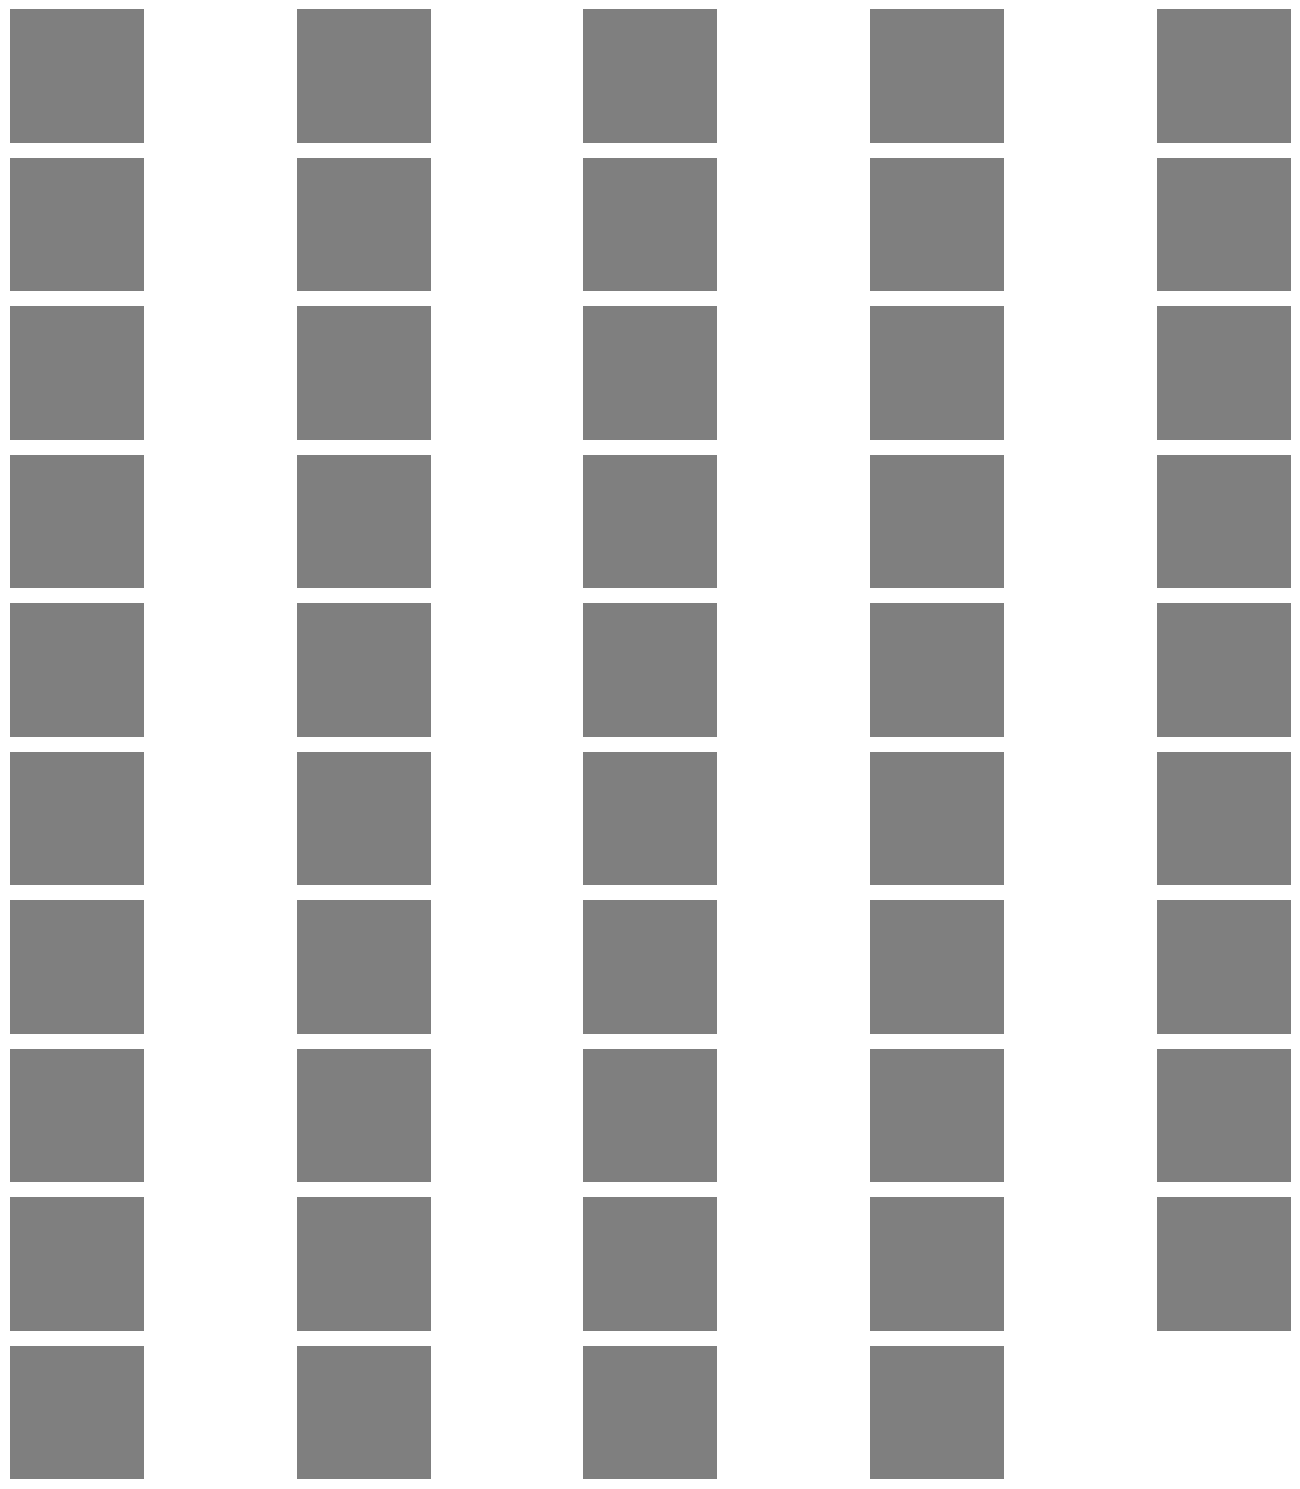

In [ ]:
diff_images = [torch.abs(test_noisy_image_list[i] - test_noisy_image_list[i - 1]) for i in range(1, len(test_noisy_image_list))]

# Display the differences
plt.figure(figsize=(15, 15))
for idx, img in enumerate(diff_images):
    plt.subplot(10, 5, idx + 1)  # 10 rows, 5 columns
    diff_img = (img.squeeze(0).permute(1, 2, 0).numpy() + 1) / 2
    plt.imshow(diff_img.clip(0, 1))
    plt.axis("off")
plt.tight_layout()
plt.show()
